In [15]:
%matplotlib inline
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

# Visualización

## ONI

In [2]:
# %load src/oni_plot.py
def plot_oni(df, min_max = None, vline=None, ax=None):
    
    import pandas as pd
    import matplotlib.pyplot as plt
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(13,4))
    
    oni_melted = pd.melt(df, id_vars="0", value_name="ONI", var_name="Month")
    oni_melted["Date"] = oni_melted.apply(lambda x: pd.to_datetime(str(x[0]) +"-"+ str(x["Month"])).to_period("M"), axis=1)
    oni = oni_melted[["Date", "ONI"]].sort_values("Date").reset_index(drop=True).set_index("Date")
    if min_max is not None:
        oni = oni[str(min_max[0]):str(min_max[1])]        

    oni.plot(ax=ax, color="k")
    ax.fill_between(oni.index, 0.5, oni.ONI, where=oni.ONI >= 0.5,color="red", label="El Nino", interpolate=True)
    ax.fill_between(oni.index, -0.5, oni.ONI, where=oni.ONI <= -0.5,color="blue", label="La Nina", interpolate=True)
    ax.grid()
    ax.legend()
    ax.set_ylim(-3,3)
    ax.set_title("Ocean Nino Index (ONI)", size=14)
    
    if vline is not None:
        ax.axvline(str(vline), color="green", linestyle="dashed");
        

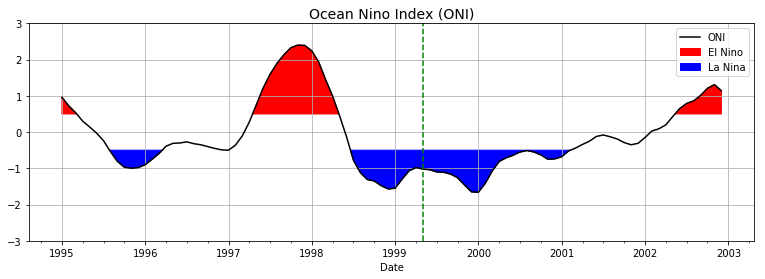

In [3]:
oni = pd.read_csv("./data/oni.txt")
#fig, ax = plt.subplots(figsize=(13,4))
plot_oni(oni, min_max = [1995, 2002], vline="1999-5")

## TRMM anomalía mensual

In [4]:
ds = xr.open_dataset("./data/processed/peru_anomaly.nc")
ds

<xarray.Dataset>
Dimensions:        (nlat: 85, nlon: 63, time: 242)
Coordinates:
  * nlon           (nlon) float32 -82.375 -82.125 -81.875 -81.625 -81.375 ...
  * nlat           (nlat) float32 -20.125 -19.875 -19.625 -19.375 -19.125 ...
  * time           (time) datetime64[ns] 1998-01-31 1998-02-28 1998-03-31 ...
    month          (time) int64 ...
Data variables:
    precipitation  (time, nlat, nlon) float32 ...

In [5]:
# %load src/plot_map.py
def plot_map(ds, values=None, contour=False, 
             max_value=350, min_value=-350, title=None, ax=None, **kwargs):
    levels = np.arange(min_value, max_value+50, 50)
    
    if ax is None:
        ax = plt.axes(projection=ccrs.Orthographic(-70,-15))
    
    p = ds["precipitation"].plot.contourf(ax=ax, transform=ccrs.PlateCarree(), 
                         vmin=min_value, vmax=max_value, 
                         center=0, levels=levels, extend="both", cmap="RdBu",  
                                          cbar_kwargs={'label': "Precipitación en mm"})
    ax.coastlines(color="red")
    ax.add_feature(cartopy.feature.BORDERS, edgecolor="red")
    ax.gridlines()
    ax.set_extent([-82, -68.5, 0.5, -18]); #x0, x1, y0, y1 
    if title is None:
        title =""
    elif isinstance(title, str):
        pass
    else:
        title = pd.to_datetime(ds.time.values).strftime("%Y-%m")
    ax.set_title(title, size=16)

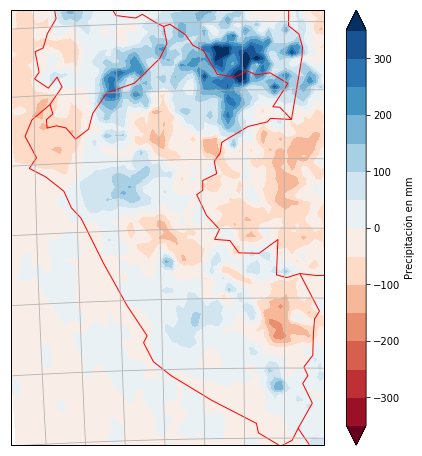

In [6]:
fig = plt.figure(figsize=(8,8))
_ = plot_map(ds.sel(time=ds.time[110]))

## Anotación

Text(0.01,0.05,' - Ocean Nino Index (ONI), NOAA')

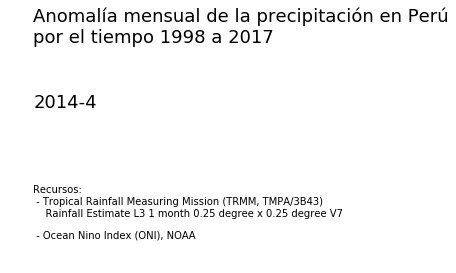

In [7]:
fig, ax = plt.subplots()
    
ax.axis("off")
ax.annotate(xy=(0.01,0.95) ,s="Anomalía mensual de la precipitación en Perú\npor el tiempo 1998 a 2017", size=18)
ax.annotate(xy=(0.01,0.65) ,s="2014-4", size=18)
ax.annotate(xy=(0.01,0.15) ,s="Recursos:\n - Tropical Rainfall Measuring Mission (TRMM, TMPA/3B43)\n    Rainfall Estimate L3 1 month 0.25 degree x 0.25 degree V7", size=10)
ax.annotate(xy=(0.01,0.05) ,s=" - Ocean Nino Index (ONI), NOAA", size=10);

### Refactorización

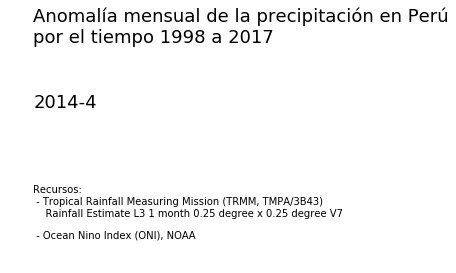

In [8]:
# %load src/annotation.py
def annotation(ax=None, date="2014-4"):
    import matplotlib.pyplot as plt
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axis("off")
    ax.annotate(xy=(0.01,0.95) ,s="Anomalía mensual de la precipitación en Perú\npor el tiempo 1998 a 2017", size=18)
    ax.annotate(xy=(0.01,0.65) ,s=date, size=18)
    ax.annotate(xy=(0.01,0.15) ,s="Recursos:\n - Tropical Rainfall Measuring Mission (TRMM, TMPA/3B43)\n    Rainfall Estimate L3 1 month 0.25 degree x 0.25 degree V7", size=10)
    ax.annotate(xy=(0.01,0.05) ,s=" - Ocean Nino Index (ONI), NOAA", size=10)

annotation()

## Trazado

[Matplotlib GridSpec](https://matplotlib.org/users/gridspec.html)

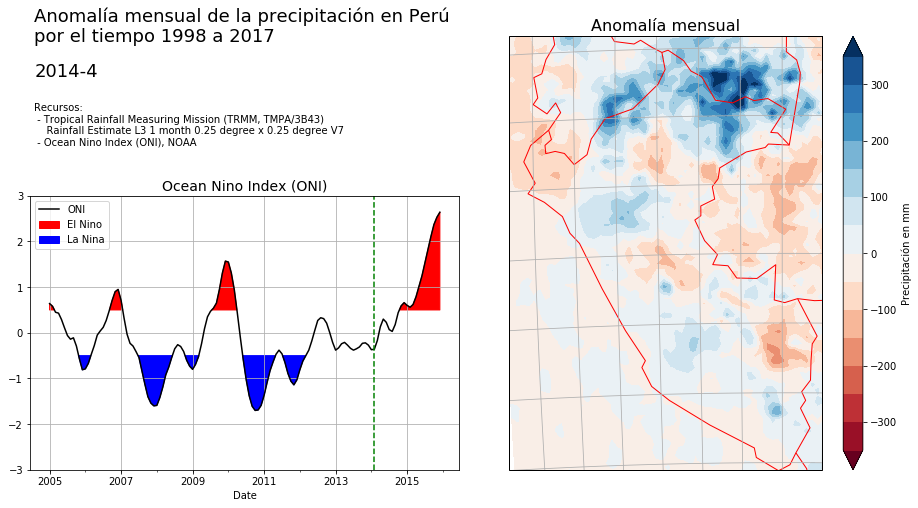

In [9]:
import matplotlib.gridspec as gridspec
plt.figure(figsize=(13, 7))
G = gridspec.GridSpec(3, 4)
ax0 = plt.subplot(G[0, :-2])
ax1 = plt.subplot(G[1:3, :-2])
ax2 = plt.subplot(G[:3, 2:],projection=ccrs.Orthographic(-70,-15))
plot_oni(oni, min_max = [2005, 2015], vline="2014-2", ax=ax1)
plot_map(ds.sel(time=ds.time[110]), ax=ax2, title="Anomalía mensual")
annotation(ax=ax0)
plt.tight_layout()

### Refactorización

In [10]:
# %load src/final_plot.py
def final_plot(ds, min_max=["1997-10", "2018-3"]):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from matplotlib import rcParams
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.sans-serif'] = ['Arial']
    
    date = pd.to_datetime(ds.time.values).strftime("%Y-%m")
    
    plt.figure(figsize=(13, 7))
    G = gridspec.GridSpec(3, 4)
    ax0 = plt.subplot(G[0, :-2])
    ax1 = plt.subplot(G[1:3, :-2])
    ax2 = plt.subplot(G[:3, 2:],projection=ccrs.Orthographic(-70,-15))
    
    annotation(ax=ax0, date=date)
    plot_oni(oni, min_max=min_max, vline=date, ax=ax1)
    plot_map(ds, ax=ax2, title="Anomalía mensual ({})".format(date))    
    plt.tight_layout()

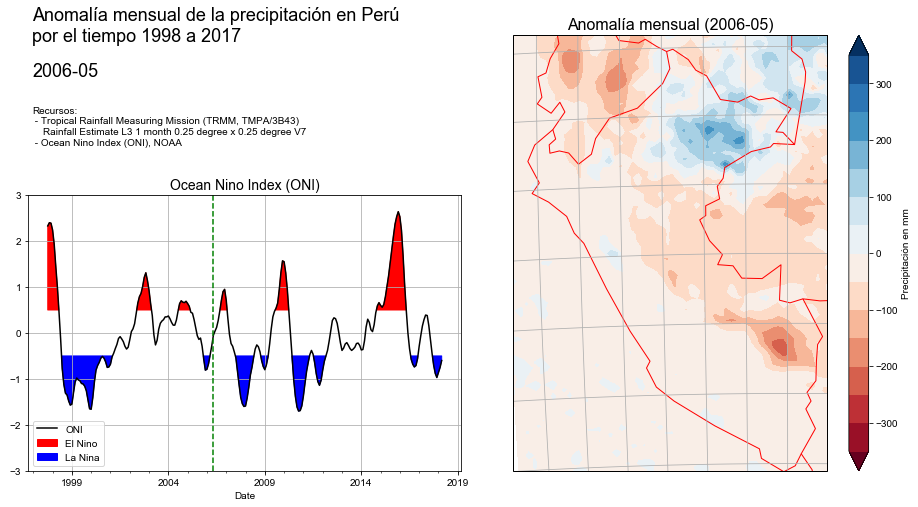

In [11]:
final_plot(ds=ds.sel(time=ds.time[100]))

### Almacenar los datos en el disco

In [12]:
def save_figures(ds, dpi=150):
    print("Processing ...\n")
    for e, _ in enumerate(ds.time):    
        if e%25==0:
            print("{} out from {} ...".format(e, len(ds.time)))
        final_plot(ds=ds.sel(time=ds.time[e]))
        date_title = pd.to_datetime(ds.time[e].values).strftime("%Y-%m") 
        plt.savefig("./figures/{}.png".format(date_title), bbox_inches="tight", dpi=dpi)
        plt.close()
    print("Done!")

In [13]:
save = True
if save:
    save_figures(ds, dpi=75)   

Processing ...

0 out from 242 ...
25 out from 242 ...
50 out from 242 ...
75 out from 242 ...
100 out from 242 ...
125 out from 242 ...
150 out from 242 ...
175 out from 242 ...
200 out from 242 ...
225 out from 242 ...
Done!


### Cargar datos del disco y hacer una animación

In [16]:
import imageio
file_list = sorted(glob.glob("./figures/*.png"))

with imageio.get_writer('./annimation/monthly_rainfall.gif', mode='I', duration=0.5) as writer:
    print("Processing ...\n")
    for e, filename in enumerate(file_list):
        if e%25==0:
            print("{} out from {} ...".format(e, len(ds.time)))
        image = imageio.imread(filename)
        writer.append_data(image)
    print("Done!")

Processing ...

0 out from 242 ...
25 out from 242 ...
50 out from 242 ...
75 out from 242 ...
100 out from 242 ...
125 out from 242 ...
150 out from 242 ...
175 out from 242 ...
200 out from 242 ...
225 out from 242 ...
Done!
